In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

# Задача

В данном задании вам предлагается решить задачу извлечения аргументов (объектов, аспектов и предикатов) из предложения. Такая модель должна быть обучена на предложениях, где слова или фразы имеют разметку последовательности – каждому слову соответствует его тег.

> **Пример.** Postgres is easier to install and maintain than Oracle.
>
> [Postgres **OBJECT**] is [easier **PREDICATE**] to [install **ASPECT**] and [maintain **ASPECT**] than [Oracle **OBJECT**].

> Сущности могут состоять из нескольких слов: Advil works better for body aches and pains than Motrin.
>
> [Advil **OBJECT**] works [better **PREDICATE**] for [body aches **ASPECT**] and [pains **ASPECT**] than [Motrin **OBJECT**].

Данные состоят из сравнительных предложений (т.е. предложений, содержащих сравнение двух или более объектов). В предложениях содержится следующая информация:

-	*Объекты* – объекты, которые сравниваются
-	*Аспекты* – характеристики, по которым сравниваются объекты
-	*Сказуемое* – слова или фразы, которые реализуют сравнение (обычно сравнительные прилагательные или наречия)

В наборе данных используется схема BIO:

- Первое слово сущности помечается тегом `B-<entity-type>` (начало сущности).
- Второе и последующие слова сущности помечаются тегом `I-<entity-type>` (внутри сущности).
- Слова, которые не являются частью сущности, помечаются тегом `O` (вне сущности).

Поэтому в нашем наборе данных используются следующие метки:
- O
- B-Object
- I-Object
- B-Aspect
- I-Aspect
- B-Predicate
- I-Predicate

**Ваша задача** – присвоить одну из таких меток каждому токену данных путем обучения модели на основе LSTM.


# Data loading

In [4]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [5]:
def read_dataset(filename, splitter="\t"):
    data = []
    sentence = []
    tags = []
    with open(filename) as f:
        for line in f:
            if not line.isspace():
                word, tag = line.split(splitter)
                sentence.append(word)
                tags.append(tag.strip())
            else:
                data.append((sentence, tags))
                sentence = []
                tags = []
    return data

In [6]:
!gdown 1wkfEJCUKF5nbZ6lV6HlRtcEaNkLrLo7y

Downloading...
From: https://drive.google.com/uc?id=1wkfEJCUKF5nbZ6lV6HlRtcEaNkLrLo7y
To: /content/train.tsv
100% 599k/599k [00:00<00:00, 94.9MB/s]


In [7]:
!gdown 10kS7glt0sLoh6UIn0RtpREW-zcU_zIay

Downloading...
From: https://drive.google.com/uc?id=10kS7glt0sLoh6UIn0RtpREW-zcU_zIay
To: /content/test_no_answer.tsv
100% 43.1k/43.1k [00:00<00:00, 82.0MB/s]


In [8]:
training_data = read_dataset("train.tsv")

In [9]:
training_data[0]

(['also',
  ',',
  'i',
  'have',
  'recently',
  'discovered',
  'advil',
  'liquigels',
  'work',
  'much',
  'better',
  'and',
  'faster',
  'for',
  'a',
  'headache',
  'than',
  'regular',
  'ibuprofen',
  '.'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Object',
  'O',
  'O',
  'O',
  'B-Predicate',
  'O',
  'B-Predicate',
  'O',
  'O',
  'B-Aspect',
  'O',
  'O',
  'B-Object',
  'O'])

In [10]:
test_data = read_dataset("test_no_answer.tsv", splitter="\n")

In [11]:
test_data[0]

(['meanwhile',
  ',',
  'though',
  'windows',
  '8',
  'is',
  'significantly',
  'at',
  'greater',
  'risk',
  '(',
  '1',
  '.',
  '73',
  'percent',
  ')',
  'compared',
  'to',
  'windows',
  '8',
  '.',
  '1',
  ',',
  'according',
  'to',
  'redmond',
  "'",
  's',
  'report',
  ',',
  'it',
  "'",
  's',
  'still',
  'significantly',
  'safer',
  'than',
  'windows',
  '7',
  ',',
  'windows',
  'xp',
  ',',
  'or',
  'windows',
  'vista',
  '.'],
 ['',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  ''])

In [12]:
word_to_ix = {}

# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index

for sent, tags in test_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index


tag_to_ix = {
    "O": 0,
    "B-Object": 1,
    "I-Object": 2,
    "B-Aspect": 3,
    "I-Aspect": 4,
    "B-Predicate": 5,
    "I-Predicate": 6
}  # Assign each tag with a unique index

idx_to_tag = dict(map(reversed, tag_to_ix.items()))

EMBEDDING_DIM = 32
HIDDEN_DIM = 64

# Tagger

Опишите архитектуру нейросети. Все необходимые слои описаны в комментариях. В качестве выхода из модели используйте логистический softmax:

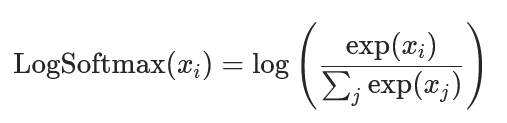

In [54]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        torch.manual_seed(5)
        torch.cuda.manual_seed(5)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        self.hidden_dim = hidden_dim
        # The Embedding layer with size of the dictionary vocab_size
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

# Training

Обучите модель с представленными ниже параметрами.

In [55]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [56]:
# with torch.no_grad():
#     inputs = prepare_sequence(training_data[0][0], word_to_ix)
#     tag_scores = model(inputs)

for epoch in tqdm(range(10)):  # normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

100%|██████████| 10/10 [00:43<00:00,  4.30s/it]


# Inference
Предскажите метки для слов из первого предложения.

In [57]:
with torch.no_grad():
    sentence = test_data[0][0]
    inputs = prepare_sequence(sentence, word_to_ix)
    tag_scores = model(inputs)
    tags = [idx_to_tag[int(i)] for i in tag_scores.argmax(dim=-1)]

    for i, y in zip(sentence, tags):
        print(i, y)

meanwhile O
, O
though O
windows O
8 O
is O
significantly O
at O
greater B-Predicate
risk O
( O
1 O
. O
73 O
percent O
) O
compared O
to O
windows O
8 O
. O
1 O
, O
according O
to O
redmond O
' O
s O
report O
, O
it O
' O
s O
still O
significantly O
safer B-Predicate
than O
windows O
7 O
, O
windows O
xp O
, O
or O
windows O
vista O
. O


Предскажите метки для слов из десятого предложения.

In [58]:
with torch.no_grad():
    sentence = test_data[10][0]
    inputs = prepare_sequence(sentence, word_to_ix)
    tag_scores = model(inputs)
    tags = [idx_to_tag[int(i)] for i in tag_scores.argmax(dim=-1)]

    for i, y in zip(sentence, tags):
        print(i, y)

but O
that O
aside O
, O
windows O
10 O
is O
still O
easier B-Predicate
to O
navigate B-Aspect
than O
mac B-Object
os O
x O
and O
windows O
8 O
, O
has O
better B-Predicate
access B-Aspect
to O
files O
than O
in O
android O
, O
and O
is O
faster B-Predicate
, O
more B-Predicate
flexible I-Predicate
and O
more B-Predicate
capable B-Aspect
than O
windows O
xp O
and O
the O
home O
and O
enterprise O
editions O
of O
windows O
7 O
. O


Предскажите метки для слов из сотого предложения.

In [59]:
with torch.no_grad():
    sentence = test_data[100][0]
    inputs = prepare_sequence(sentence, word_to_ix)
    tag_scores = model(inputs)
    tags = [idx_to_tag[int(i)] for i in tag_scores.argmax(dim=-1)]

    print(tags.count('O'))

32


Сохраните результаты предсказания на тестовом наборе (`test_data`) в файл, запустив код ниже.

In [60]:
with open("out_test.tsv", "w") as w:
    with torch.no_grad():
        for sentence in tqdm(test_data):
            inputs = prepare_sequence(sentence[0], word_to_ix)
            tag_scores = model(inputs)
            tags = [idx_to_tag[int(i)] for i in tag_scores.argmax(dim=-1)]
            for i, y in zip(sentence[0], tags):
                w.write(f"{i}\t{y}\n")
            w.write("\n")


100%|██████████| 283/283 [00:00<00:00, 1451.79it/s]


Файл `test.tsv` содержит разметку тестовых данных. Сравните файлы построчно, запустив код ниже. Сколько суммарно меток было предсказано верно (то есть сколько строк совпало)?

In [25]:
!gdown 1mUtlDtb7naXDi1U8x73UdyncnHv1BOjd

Downloading...
From: https://drive.google.com/uc?id=1mUtlDtb7naXDi1U8x73UdyncnHv1BOjd
To: /content/test.tsv
100% 81.1k/81.1k [00:00<00:00, 91.6MB/s]


In [61]:
points = 0
with open("test.tsv", "r") as f_eval, open("out_test.tsv", "r") as f:
  for line_eval, line in zip(f_eval.readlines(), f.readlines()):
    if line_eval == line: points += 1
    # else:
    #   print(f'line_eval {line_eval}line {line}')
print(points)

7375


Правильный ответ теста: 7375